<a href="https://colab.research.google.com/github/noy2121/CIFAR10-Image-Classification-using-ResNet/blob/main/Cifar10Classifer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **ResNet Classification Model for CIFAR10 Dataset**
CIFAR10 has 60,000 images divided into the following  10 labels:
1. Airplane
2. Automobile
3. Bird
4. Cat
5. Deer
6. Dog
7. Frog
8. Horse
9. Ship
10. Truck

* Every image is of the form (32x32x3)
* Using google colaboratory, I've design a model which predict the label of an image correctly
* Data Source: https://www.cs.toronto.edu/~kriz/cifar.html

In [1]:
# Run some setup code for this notebook

import random
import numpy as np
import keras
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules
%load_ext autoreload
%autoreload 2

# **Load Data**


In [2]:
# Load the raw CIFAR-10 data
# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_trn, y_trn
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass
   
# Load data and train_test split it
(X_trn, y_trn), (X_test, y_test) = keras.datasets.cifar10.load_data()

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_trn.shape)
print('Training labels shape: ', y_trn.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

170500096/170498071 [==============================] - 2s 0us/step
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000, 1)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 1)


# **Some Examples from the dataset**

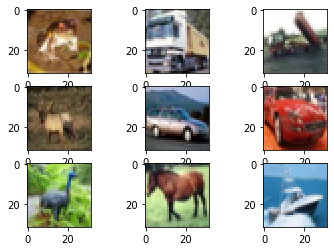

In [3]:
# Visualize some examples from the dataset
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(X_trn[i])
# show the figure
plt.show()

# **Data Preprocessing**
* Split the training set into train and validation sets
* Augment the data

In [4]:
# Data Preprocessing
# Create training and val sets
(X_train, y_train) = X_trn[:40000, ...], y_trn[:40000, ...]
y_train = y_train.ravel()
(X_val, y_val) = X_trn[40000:50000, ...], y_trn[40000:50000, ...]
y_val = y_val.ravel()

In [5]:
# Import the libraries
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

# one-hot encode
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
# Data augmentation
train_datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1,
                          shear_range=0.15, zoom_range=0.15, horizontal_flip=True)
train_datagen.fit(X_train)
print('Training data shape: ', X_train.shape)
print('Training labels shape : ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation data labels: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (40000, 32, 32, 3)
Training labels shape :  (40000, 10)
Validation data shape:  (10000, 32, 32, 3)
Validation data labels:  (10000, 10)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 1)


#**Build Model Architecture**

In [6]:
### Implementation of ResNet

# import the libraries
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import AveragePooling2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import add
from keras.models import Model
from keras.regularizers import l2
from keras import backend as K


class ResNet:
	@staticmethod
	def residual_module(data, K, stride, chanDim, red=False, reg=0.0001, bnEps=2e-5, bnMom=0.9):
		"""
		data: input to the residual module
		K: number of filters that will be learned by the final CONV layer (the first two CONV layers will learn K/4 filters)
		stride: controls the stride of the convolution (will help us reduce spatial dimensions without using max pooling)
		chanDim: defines the axis which will perform batch normalization
		red: (reduce) will control whether we are reducing spatial dimensions (True) or not (False) as not all residual modules will reduce dimensions of our spatial volume
		reg: applies regularization strength for all CONV layers in the residual module
		bnEps: controls the Ɛ responsible for avoiding “division by zero” errors when normalizing inputs
		bnMom: controls the momentum for the moving average
		"""
		# the shortcut branch of the ResNet module should be initialize as the input (identity) data
		shortcut = data

		# the first block of the ResNet module are the 1x1 CONVs
		# BN ==> ReLu ==> CONV layer ==> pattern
		bn1 = BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(data)
		act1 = Activation('relu')(bn1)
		conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias=False, kernel_regularizer=l2(reg))(act1)

		# the second block of the ResNet module are the 3x3 CONVs
		bn2 = BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(conv1)
		act2 = Activation('relu')(bn2)
		conv2 = Conv2D(int(K * 0.25), (3, 3), strides=stride, padding='same', use_bias=False,
				kernel_regularizer=l2(reg))(act2)

		# the third block of the ResNet module are 1x1 CONVs
		# we increase dims applying K filters with dims 1x1
		bn3 = BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(conv2)
		act3 = Activation('relu')(bn3)
		conv3 = Conv2D(K, (1, 1), use_bias=False, kernel_regularizer=l2(reg))(act3)

		# to avoid applying max pooling, we need to check if reducing spatial dimensions is necessary
		# if we are to reduce the spatial size, apply CONV layer to the shortcut
		if red:
			shortcut = Conv2D(K, (1, 1), strides=stride, use_bias=False, kernel_regularizer=l2(reg))(act1)

		# add together the shortcut and the final CONV
		x = add([conv3, shortcut])

		# return the addition as the output of the ResNet module
		return x

	@staticmethod
	def build(width, height, depth, classes, stages, filters, reg=0.0001, bnEps=2e-5, bnMom=0.9):
		# initialize the input shape to be "channels last" and the channels dim itself
		inputShape = (height,width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape and the channels dim
		if K.image_data_format() == "channels first":
			inputShape = (depth, height, width)
			chanDim = 1

		# set the input and apply BN
		inputs = Input(shape=inputShape)
		x = BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(inputs)

		# apply CONV ==> BN ==> ReLu ==> POOL to reduce spatial size
		x = Conv2D(filters[0], (5, 5), use_bias=False, padding='same', kernel_regularizer=l2(reg))(x)
		x = BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(x)
		x = Activation('relu')(x)
		x = ZeroPadding2D((1, 1))(x)
		x = MaxPooling2D((3, 3), strides=(2, 2))(x)

		# loop over the number of stages
		for i in range(0,len(stages)):
			# initialize the stride, then apply residual module
			# used to reduce spatial size of the input volume
			stride = (1, 1) if i == 0 else (2, 2)
			x = ResNet.residual_module(x, filters[i + 1], stride, chanDim, red=True,
									bnEps=bnEps, bnMom=bnMom)

			# loop over the number of layers in each stage
			for j in range(0, stages[i] - 1):
				# apply ResNet module
				x = ResNet.residual_module(x, filters[i + 1], (1, 1), chanDim, bnEps=bnEps, bnMom=bnMom)

		# apply BN ==> ReLu ==> POOL
		x = BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(x)
		x = Activation("relu")(x)
		x = AveragePooling2D((4, 4))(x)
		# softmax classifier
		x = Flatten()(x)
		x = Dense(classes, kernel_regularizer=l2(reg))(x)
		x = Activation("softmax")(x)
		# create the model
		model = Model(inputs, x, name="resnet")
		# return the constructed network architecture
		return model


# **Model Training**
* Setup number of layers, number of residual blocks, lr, optimizer, epochs and batch size
* Compile the model 
* Fit model to the *X_train, y_train*


In [7]:
# Create model, and compile it
model = ResNet.build(32, 32, 3, 10, [3, 6], [32, 64, 128])
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   2400        batch_normalization[0][0]        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32)   128         conv2d[0][0]                     
_____________________________________________________________________________________________

In [8]:
# Begin training
hist = model.fit(train_datagen.flow(X_train, y_train, batch_size=32),
                 validation_data=(X_val, y_val), epochs = 100, shuffle=True)

Epoch 1/100
1250/1250 [==============================] - 314s 251ms/step - loss: 1.6744 - accuracy: 0.4276 - val_loss: 1.4675 - val_accuracy: 0.5257
Epoch 2/100
1250/1250 [==============================] - 312s 249ms/step - loss: 1.3164 - accuracy: 0.5727 - val_loss: 1.1811 - val_accuracy: 0.6239
Epoch 3/100
1250/1250 [==============================] - 304s 244ms/step - loss: 1.1496 - accuracy: 0.6385 - val_loss: 1.0110 - val_accuracy: 0.6934
Epoch 4/100
1250/1250 [==============================] - 304s 243ms/step - loss: 1.0417 - accuracy: 0.6791 - val_loss: 1.0929 - val_accuracy: 0.6696
Epoch 5/100
1250/1250 [==============================] - 305s 244ms/step - loss: 0.9724 - accuracy: 0.7057 - val_loss: 0.8717 - val_accuracy: 0.7433
Epoch 6/100
1250/1250 [==============================] - 305s 244ms/step - loss: 0.9290 - accuracy: 0.7225 - val_loss: 0.9091 - val_accuracy: 0.7328
Epoch 7/100
1250/1250 [==============================] - 307s 245ms/step - loss: 0.8883 - accuracy: 0.7380

# **Evaluate Model on the Validation Set**

In [9]:
# Save model
# Insert path where you want to save the model
model.save('/content/drive/My Drive/DL_Projects/Cifar10Classifier')
print('Model saved!')
# Evaluate the model
scores = model.evaluate(X_val, y_val, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/DL_Projects/Cifar10Classifier/assets
Model saved!
313/313 [==============================] - 15s 48ms/step - loss: 0.5836 - accuracy: 0.8608
Validation loss: 0.5836049318313599
Validation accuracy: 0.86080002784729


In [10]:
from sklearn.metrics import classification_report
# Print scores
y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1)
y_val = np.argmax(y_val, axis=1)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1014
           1       0.90      0.97      0.93      1014
           2       0.85      0.80      0.82       952
           3       0.82      0.62      0.71      1016
           4       0.89      0.85      0.87       997
           5       0.77      0.81      0.79      1025
           6       0.79      0.94      0.86       980
           7       0.88      0.90      0.89       977
           8       0.96      0.89      0.92      1003
           9       0.93      0.91      0.92      1022

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



# **Graphs**
* *training loss* vs *validation loss*
* *training accuracy* vs *validation accuracy*


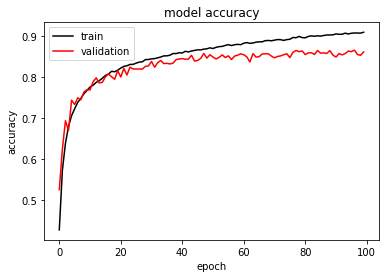

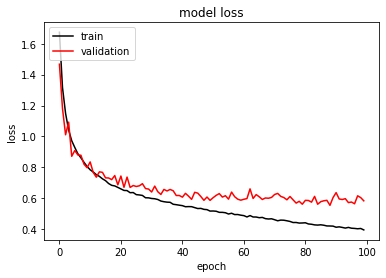

In [11]:
# Plot of model accuracy on train and validation datasets
plt.plot(hist.history['accuracy'], color='black')
plt.plot(hist.history['val_accuracy'], color='red')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Plot of model loss on train and validation datasets
plt.plot(hist.history['loss'], color='black')
plt.plot(hist.history['val_loss'], color='red')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# **Test Model on Test Set** 


In [13]:
# CIFAR10 labels
cifar10_labels = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                           'dog', 'frog', 'horse', 'ship', 'truck'])

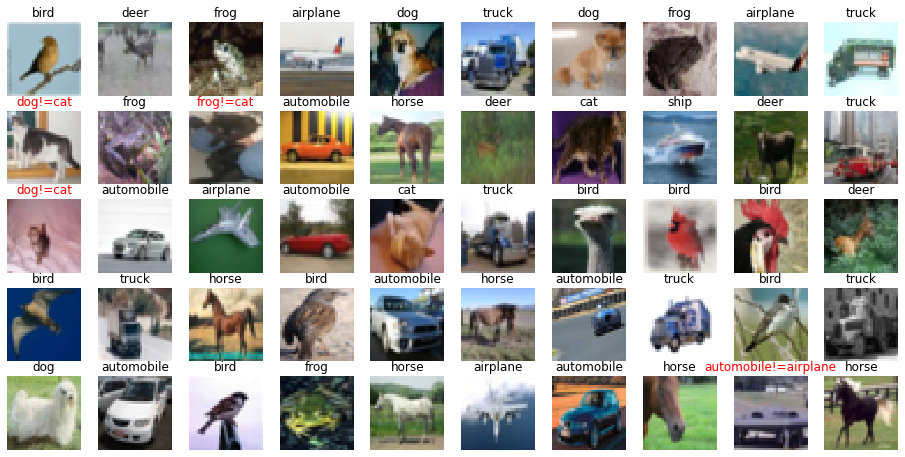

Number of correct answers: 46
Number of wrong answers: 4
Correct answer rate: 92.0 %


In [14]:
# Load model and predict X_test

# model = keras.models.load_model('/content/Cifar10Classifier/best_model.h5')
# print('Model loaded!')
def convertData(image):
    img = image.astype('float32')
    img_arr = np.zeros(32*32*3).reshape((1,32,32,3))
    img_arr[0] = img
    return img_arr

plt.figure(figsize=(16,16))
right = 0
mistake = 0

for i in range(50):
    index = random.randint(0, X_test.shape[0])
    image = X_test[index]
    data = convertData(image)
    plt.subplot(10, 10, i+1)
    plt.imshow(image)
    plt.axis('off')

    # Predict the data
    prediction = model.predict(data, batch_size=1) 
    bestnum = 0.0
    bestclass = 0
    for n in [0,1,2,3,4,5,6,7,8,9]:
        if bestnum < prediction[0][n]:
            bestnum = prediction[0][n]
            bestclass = n

    if y_test[index] == bestclass:
      plt.title(cifar10_labels[bestclass])
      right += 1
    else:
      plt.title(cifar10_labels[bestclass] + '!=' + cifar10_labels[int(y_test[index][0])], color='red')
      mistake += 1
                                                                   
plt.show()
print("Number of correct answers:", right)
print("Number of wrong answers:", mistake)
print("Correct answer rate:", right/(mistake + right)*100, '%')


# **Notes**
* With optimizers: adam, adamax, RMSprop accuracy tends to be less then 85%
* Different architectures:
  - [3, 7] stages [32, 64, 128] filters
  - [3, 4, 6] stages [32, 64, 128, 256] filters
  tends to be less then 85%
* Next step: improve network accuracy using Data Augmentation and Standardization